In [235]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import log_loss
from scipy.special import logsumexp
from sklearn.manifold import TSNE
import h5py
import pickle
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [103]:
np.random.seed(0)

In [104]:
dataset_path = os.getcwd() + '/Assignment3-Data/MNIST_Subset.h5'

In [105]:
data = h5py.File(dataset_path, 'r')

In [106]:
train_data = np.zeros((14251, 28, 28))
train_label = np.zeros((14251,))

In [107]:
data['X'].read_direct(train_data)
data['Y'].read_direct(train_label)

In [108]:
train_label = train_label.astype(np.int64)

In [109]:
label = np.zeros((14251, 2))

In [110]:
for i in range(0, train_label.shape[0]):
    if(train_label[i] == 7):
        # first col
        label[i, 0] = 1
    else:
        label[i, 1] = 1
        

In [111]:
train_data = np.reshape(train_data, (train_data.shape[0], -1))

In [112]:
# io.imshow(train_data[0,:,:], cmap='gray')
# plt.show()

In [113]:
# Train, Valid, Test split
X_train, X_test, y_train, y_test = train_test_split(
    train_data, label, test_size=0.10, random_state=0)


X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.11, random_state=0)


In [114]:
print('Training set ', X_train.shape, y_train.shape)
print('Valid set ', X_valid.shape, y_valid.shape)
print('Test set ', X_test.shape, y_test.shape)

Training set  (11414, 784) (11414, 2)
Valid set  (1411, 784) (1411, 2)
Test set  (1426, 784) (1426, 2)


In [115]:
# Preprocess data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [183]:
class NN():
    def __init__(self, inputLayerSize, hiddenLayers, outputLayerSize, learning_rate):
        self.inputLayerSize = inputLayerSize
        self.hiddenLayers = hiddenLayers
        self.outputLayerSize = outputLayerSize
        self.lr = learning_rate
        self.w = []
        self.b = []
        self.a = [] # after applying activation
        self.z = [] # pre activation value
        self.a_s = []
        self.train_loss_iter = []
        self.test_loss_iter = []
        self.test_accuracy_iter = []
        self.valid_loss_iter = []
        self.train_accuracy_iter = []
        self.valid_accuracy_iter = []
        self.z_s = []
        self.errors = []
        self.w.append(np.random.randn(inputLayerSize, hiddenLayers[0]))
        self.b.append(np.random.randn(hiddenLayers[0], 1))
#         self.b.append(np.zeros((hiddenLayers[0], 1)))
            
#         for i in range(0, len(hiddenLayers)-1):
        i = 0
        while (i <= (len(hiddenLayers)-1)):
            
#             print(i)
            if(i < (len(hiddenLayers)-1)):
#                 self.w.append(np.random.randn(hiddenLayers[i], hiddenLayers[i+1])* np.sqrt(2/hiddenLayers[i+1]))
                self.w.append(np.random.randn(hiddenLayers[i], hiddenLayers[i+1]))
                self.b.append(np.random.randn(hiddenLayers[i+1], 1))
#                 self.b.append(np.zeros((hiddenLayers[i+1], 1)))
        
            if(i == (len(hiddenLayers)-1)):
                self.w.append(np.random.randn(hiddenLayers[i], outputLayerSize))
                self.b.append(np.random.randn(outputLayerSize, 1))
#                 self.b.append(np.zeros((outputLayerSize, 1)))
                break
                
            i+=1
        
    def forward(self, X):
        # X: no. of datapts x no. of input neurons
        # first clear vars
        self.a.clear()
        self.z.clear()
        self.a_s.clear()
        self.a_s.clear()
        self.errors.clear()
        
        h1 = X @ self.w[0] + self.b[0].T # hidden layer 1 output
        a1 = self.sigmoid(h1)          # apply activation on layer 1 output
        
        self.z.append(h1)
#         print(a1.shape)
        self.a.append(a1)
#         print(h1.shape, a1.shape)
        
        for i in range(1, len(self.w)-1):  # rest layers
            linear_value = self.a[i-1] @ self.w[i] + self.b[i].T
            self.z.append(linear_value)
            activation_value = self.sigmoid(linear_value)
            self.a.append(activation_value)
        
        h_last = self.a[-1] @ self.w[-1] #+ self.b[-1].T # output layer, no sigmoid use softmax instead
        self.z.append(h_last) 
        self.a.append(self.softmax(h_last))
        
        self.z_s.append(self.z.copy())
        output = self.a.copy()
        del self.a[-1]
            
        self.a_s.append(self.a.copy())
        return output[-1]
    
    def softmax(self, a):
#         return np.exp(a)/np.exp(a).sum()
        p = np.exp(a - a.max()) 
        q = p/p.sum()
        return q
        
    def sigmoid(self, a):
        
        return 1/(1+np.exp(-a))
    
    def sigmoid_dash(self, a):
        return self.sigmoid(a)*(1- self.sigmoid(a))
    
    def backprop(self, y_true, y_pred):
               
        error = [0] * len(self.w)
        
#         error[-1] = np.multiply(-(y_true - y_pred), self.sigmoid_dash(self.z[-1]))
        error[-1] = (y_pred - y_true)
        
        for i in range(1, len(self.hiddenLayers)+1):
#             print(i, error[-i].shape)
#             print(self.w[-i].T.shape)
#             print(self.sigmoid_dash(self.z[-(i+1)]).shape)
#             print(np.dot(self.w[-i], errors[-i].T).shape)
            error[-(i+1)] = np.dot(error[-i], self.w[-i].T) * self.sigmoid_dash(self.z[-(i+1)])
            
        self.errors.append(error)
#         for e in self.errors[0]:
#             for k in e:
#                 print(k.shape)
#         print(self.errors)
        self.a.clear()
        self.z.clear()        
        return 
    
        
    def train(self, no_of_epochs, X, y, X_valid, y_valid): # y is a 2d also
        
        for epoch in range(0, no_of_epochs):
            
            probab = []
            true_estimate = []
            valid_probab = []
            true_estimate_valid = []
            
            for i in range(0, X.shape[0]):

                # find output for this data point
                y_pred = self.forward(X[i, :].reshape(1, -1))
                probab.append(y_pred[0,0]) # 7 is positive class
                
                if(y[i, 0] == 1):
                    true_estimate.append(1)
                else:
                    true_estimate.append(0)
    #             print(X[i, :].reshape(1, -1).shape)

#                 y_pred_binary  = np.zeros((1,2))
#                 y_pred_binary[0, np.argmax(y_pred)] = 1
                
                self.backprop(y[i, :][np.newaxis, :], y_pred) 
                
                # update weights
    #             break
    #             print(self.b[3])
                for j in range(0, len(self.b)):
    #                 print(j)
                    self.b[j] = self.b[j] - self.lr * self.errors[0][j].T
                
#                 print('old', self.w[0])
                change_w = np.dot(X[i, :].reshape(1, -1).T, self.errors[0][0])
                self.w[0] = self.w[0] - self.lr * change_w
#                 print('new', self.w[0])
                
#                 print(self.a_s[0][1].shape)
                for k in range(1, len(self.w)):
                    change_w = np.dot(self.a_s[0][k-1].T, self.errors[0][k])
                    self.w[k] = self.w[k] - self.lr * change_w

                self.a.clear()
                self.z.clear()
                self.a_s.clear()
                self.z_s.clear()
                self.errors.clear()
                
            
            for j in range(0, X_valid.shape[0]):
                y_pred = self.forward(X_valid[j, :].reshape(1, -1))
                valid_probab.append(y_pred[0,0])
                
                if(y_valid[j, 0] == 1):
                    true_estimate_valid.append(1)
                else:
                    true_estimate_valid.append(0)
    #           
                
            loss = log_loss(true_estimate, probab)
            training_pred = self.predict(X)
#             print(training_pred)
            a,b = np.unique(np.sum(np.equal(training_pred, y), axis=1), return_counts=True)
#             print(a, b)
            
            valid_loss = log_loss(true_estimate_valid, valid_probab)
            valid_pred = self.predict(X_valid)
            a2, b2 = np.unique(np.sum(np.equal(valid_pred, y_valid), axis=1), return_counts=True)
            
            print('Epoch:', epoch, '| Train accuracy:', b[1]/X.shape[0],'| log loss:', loss, '| Valid. accuracy:', b2[1]/X_valid.shape[0], '| log loss:', valid_loss)
            
            self.train_loss_iter.append(loss)
            self.valid_loss_iter.append(valid_loss)
            self.train_accuracy_iter.append(b[1]/X.shape[0])
            self.valid_accuracy_iter.append(b2[1]/X_valid.shape[0])
            
            probab = []
            true_estimate = []
            valid_probab  = []
            true_estimate_valid = []
        
        return
    
    
    def predict(self, X):
        
        predictions = np.zeros((X.shape[0], 2))
        for i in range(0, X.shape[0]):
                      
            # find output for this data point
            y_pred = self.forward(X[i, :].reshape(1, -1))
#             print(X[i, :].reshape(1, -1).shape)
#             print(y_pred)
            y_pred_binary  = np.zeros((1,2))
            y_pred_binary[0, np.argmax(y_pred)] = 1
            predictions[i , :] = y_pred_binary
#         print('new')
        return predictions
    
    def test_predict(self, X, y):
        test_probab = []
        true_estimate_test = []
        
        test_pred = self.predict(X)
        
        for i in range(0, X.shape[0]):
            y_pred = self.forward(X[i, :].reshape(1, -1))
#             y_pred_binary  = np.zeros((1,2))
#             y_pred_binary[0, np.argmax(y_pred)] = 1
            
            test_probab.append(y_pred[0,0])

            if(y[i, 0] == 1):
                true_estimate_test.append(1)
            else:
                true_estimate_test.append(0)
            
        loss = log_loss(true_estimate_test, test_probab)
        a,b = np.unique(np.sum(np.equal(test_pred, y), axis=1), return_counts=True)
        acc = b[1]/X.shape[0]
        print('accuracy: ', acc, ' log loss:', loss)
        
        return 
    
    def hidden_layer_weights(self, X, no_of_features):
        
        hidden_feat = np.zeros((X.shape[0], no_of_features))
        
        for i in range(0, X.shape[0]):
                      
            # find output for this data point
            self.forward(X[i, :].reshape(1, -1))
            feat = self.a[-1].flatten()
#           get activations value of last hidden layer from self.a
            hidden_feat[i , :] = feat
        
        return hidden_feat
    
    

In [184]:
model = NN(784, [100, 50, 50], 2, 0.01)

In [185]:
N = 10
model.train(N, X_train, y_train, X_valid, y_valid)

Epoch: 0 | Train accuracy: 0.8967934115997898 | log loss: 0.2448497200577487 | Valid. accuracy: 0.888731396172927 | log loss: 0.285125999136084
Epoch: 1 | Train accuracy: 0.9272822849132644 | log loss: 0.14088241914284785 | Valid. accuracy: 0.9220411055988661 | log loss: 0.212085953506566
Epoch: 2 | Train accuracy: 0.9434028386192396 | log loss: 0.1068199740528598 | Valid. accuracy: 0.9362154500354358 | log loss: 0.17940616771589804
Epoch: 3 | Train accuracy: 0.9540038549150166 | log loss: 0.08517201886912096 | Valid. accuracy: 0.9433026222537207 | log loss: 0.16266413055644685
Epoch: 4 | Train accuracy: 0.9615384615384616 | log loss: 0.0698422873688785 | Valid. accuracy: 0.9489723600283487 | log loss: 0.1496669040995294
Epoch: 5 | Train accuracy: 0.9674960574732784 | log loss: 0.058226356499210034 | Valid. accuracy: 0.9525159461374911 | log loss: 0.1395770152844447
Epoch: 6 | Train accuracy: 0.9737164885228666 | log loss: 0.04906394749029491 | Valid. accuracy: 0.9581856839121191 | log

In [186]:
# Test result
model.test_predict(X_test, y_test)

Test accuracy:  0.9719495091164095  Test log loss: 0.07762462637156711


In [247]:
#Training result
model.test_predict(X_train, y_train)

Test accuracy:  0.9861573506220431  Test log loss: 0.035344691167555155


In [248]:
#Validation result
model.test_predict(X_valid, y_valid)

Test accuracy:  0.969525159461375  Test log loss: 0.11212213213713688


In [187]:
# Plot graphs

Text(0.5, 1.0, 'Log loss vs No. of epochs')

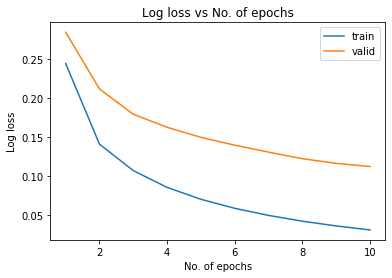

In [188]:
ax = sns.lineplot(x=list(range(1,N+1)), y=model.train_loss_iter, label='train')
sns.lineplot(x=list(range(1,N+1)), y=model.valid_loss_iter, ax = ax, label='valid')
ax.set_xlabel('No. of epochs')
ax.set_ylabel('Log loss')
ax.set_title('Log loss vs No. of epochs')

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

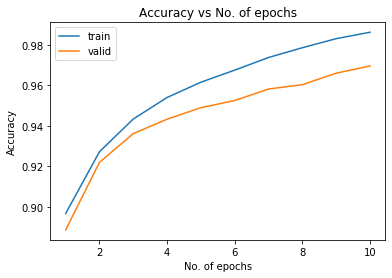

In [189]:
ax = sns.lineplot(x=list(range(1,N+1)), y=model.train_accuracy_iter, label='train')
sns.lineplot(x=list(range(1,N+1)), y=model.valid_accuracy_iter, ax = ax, label='valid')
ax.set_xlabel('No. of epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs No. of epochs')

In [190]:
nn = MLPClassifier(hidden_layer_sizes=(100,50,50), activation='logistic', solver='sgd',
                  learning_rate='constant', learning_rate_init=0.1, max_iter=10)

In [191]:
nn.fit(X_train, y_train)

/home/mayank/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 50), learning_rate='constant',
              learning_rate_init=0.1, max_iter=10, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [192]:
print('Training Accuracy: ', nn.score(X_train, y_train))

Training Accuracy:  0.9874715261958997


In [263]:
print('Training log loss: ', log_loss(y_train, nn.predict_proba(X_train)))

Training log loss:  0.045706887459882106


In [193]:
print('Validation Accuracy: ', nn.score(X_valid, y_valid))

Validation Accuracy:  0.9744861800141743


In [264]:
print('Validtion log loss: ', log_loss(y_valid, nn.predict_proba(X_valid)))

Validtion log loss:  0.07954908733625361


In [194]:
print('Test Accuracy: ', nn.score(X_test, y_test))

Test Accuracy:  0.9831697054698457


In [265]:
print('Test log loss: ', log_loss(y_test, nn.predict_proba(X_test)))

Test log loss:  0.05498110216309294


In [195]:
# TSNE on training data

In [198]:
tsne_data = model.hidden_layer_weights(X_train, 50)

In [200]:
X_embedded = TSNE(n_components=2).fit_transform(tsne_data)

In [208]:
X_embedded = np.hstack((X_embedded, y_train[:,0].reshape(-1,1)))

In [211]:
X_embedded[:,2][X_embedded[:,2] == 1] = 7
X_embedded[:,2][X_embedded[:,2] == 0] = 9

In [212]:
tsne_df = pd.DataFrame(X_embedded, columns=['x', 'y', 'class'])

Text(0.5, 1.0, 'TSNE on training data')

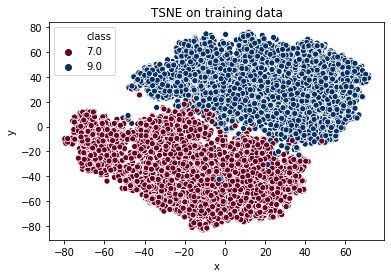

In [229]:
ax = sns.scatterplot(x='x', y='y', hue='class', legend='full', data=tsne_df, palette='RdBu')
ax.set_title('TSNE on training data')

In [230]:
# Save Model

In [244]:
model_weights = open("model_weights.pickle","wb")
pickle.dump(model.w, model_weights)
model_weights.close()

In [237]:
model_biases = open("model_biases.pickle","wb")
pickle.dump(model.b, model_biases)
model_biases.close()

In [238]:
# Load model : check

In [245]:
# pickle_in = open("model_weights.pickle","rb")
# model.w = pickle.load(pickle_in)

In [246]:
# pickle_in_bias = open("model_biases.pickle","rb")
# model.b = pickle.load(pickle_in_bias)